In [45]:
import numpy as np

def get_svd(A):
    m, n = A.shape

    # власні вектори - праві сингулярні (V)
    ATA = A.T @ A

    eigenvalues, V = np.linalg.eigh(ATA)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    V = V[:, sorted_indices]

    # можуть бути від'ємні через похибку float
    singular_values = np.sqrt(np.maximum(eigenvalues, 0))

    Sigma = np.zeros((m, n))
    min_dim = min(m, n)
    Sigma[:min_dim, :min_dim] = np.diag(singular_values[:min_dim])

    # U  u_i = (A * v_i) / sigma_i
    U = np.zeros((m, m))

    for i in range(min_dim):
        if singular_values[i] > 1e-10:
            U[:, i] = (A @ V[:, i]) / singular_values[i]
        else:
            U[:, i] = np.zeros(m)

    return U, Sigma, V.T


A = np.array([
    [3, 1, 1],
    [-1, 3, 1]
])

U, S, VT = get_svd(A)

print("\nМатриця U:\n", U)
print("\nМатриця Sigma:\n", S)
print("\nМатриця V^T:\n", VT)

A_recalc = U @ S @ VT
print("\nВідновлена матриця (U * Sigma * V^T):\n", A_recalc)

print("\nРізниця:\n", A - A_recalc)


Матриця U:
 [[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]

Матриця Sigma:
 [[3.46410162 0.         0.        ]
 [0.         3.16227766 0.        ]]

Матриця V^T:
 [[-4.08248290e-01 -8.16496581e-01 -4.08248290e-01]
 [ 8.94427191e-01 -4.47213595e-01  2.77555756e-16]
 [-1.82574186e-01 -3.65148372e-01  9.12870929e-01]]

Відновлена матриця (U * Sigma * V^T):
 [[ 3.  1.  1.]
 [-1.  3.  1.]]

Різниця:
 [[-4.44089210e-16 -8.88178420e-16 -8.88178420e-16]
 [-1.11022302e-15 -1.33226763e-15 -4.44089210e-16]]


In [46]:
import pandas as pd
file_path = 'ratings.csv'
df = pd.read_csv(file_path)
ratings_matrix_raw = df.pivot(index='userId', columns='movieId', values='rating')
ratings_matrix_raw = ratings_matrix_raw.dropna(thresh=20, axis=0)
ratings_matrix_raw = ratings_matrix_raw.dropna(thresh=10, axis=1)

ratings_matrix = ratings_matrix_raw.apply(
    lambda row: row.fillna(row.mean()),
    axis=1
)
R = ratings_matrix.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [47]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k=3)


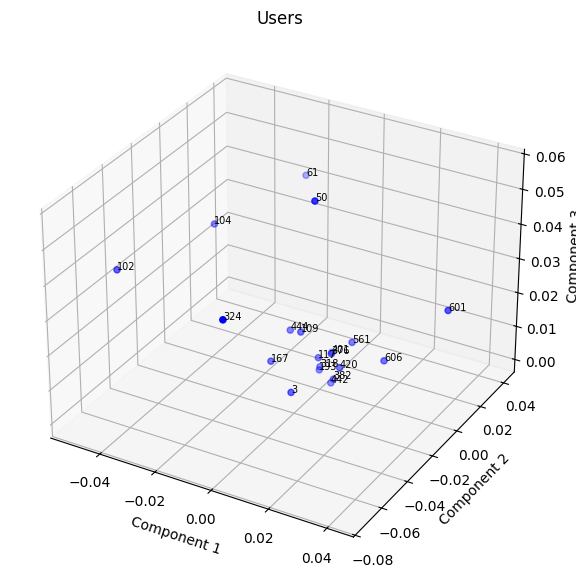

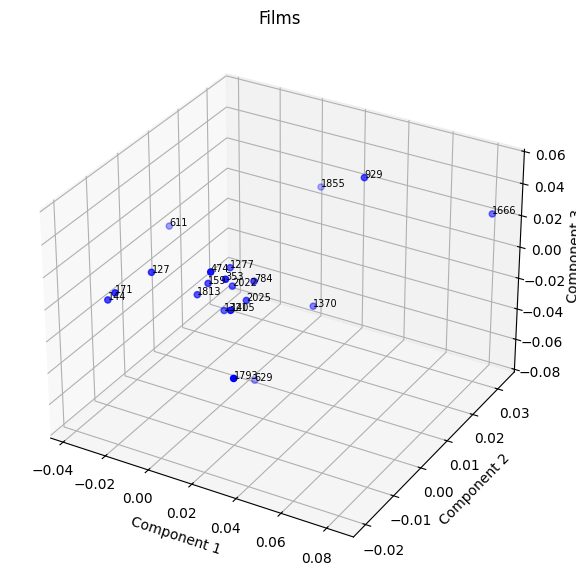

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def draw_3d_scatter(matrix, name):
    #Ця функція згенерована АІ
    num_rows = matrix.shape[0]

    random_indices = np.random.choice(num_rows, size=20, replace=False)
    subset = matrix[random_indices]
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    xs = subset[:, 0]
    ys = subset[:, 1]
    zs = subset[:, 2]

    ax.scatter(xs, ys, zs, c='b', marker='o', s=20)

    for i, idx in enumerate(random_indices):
        ax.text(xs[i], ys[i], zs[i], str(idx), fontsize=7)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title(f'{name}')

    plt.show()


draw_3d_scatter(U, "Users")
draw_3d_scatter(Vt.T, "Films")


In [81]:
U, sigma, Vt = svds(R_demeaned, k=20)
all_user_predicted_ratings = U.dot(np.diag(sigma)).dot(Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_matrix.columns, index=ratings_matrix.index)

predictions_only_df = preds_df.copy()
predictions_only_df[ratings_matrix_raw.notna()] = np.nan

movies_df = pd.read_csv('movies.csv')

def recommend_movies(user_id, preds_df, movies_df, top_k=20):
    try:
        user_predictions = preds_df.loc[user_id]
    except KeyError:
        return f"Користувача з ID {user_id} не знайдено."

    sorted_user_predictions = user_predictions.dropna().sort_values(ascending=False)
    top_recommendations = sorted_user_predictions.head(top_k)

    recs_df = pd.DataFrame({
        'movieId': top_recommendations.index,
        'predicted_rating': top_recommendations.values
    })

    final_recs = recs_df.merge(movies_df, on='movieId', how='left')
    return final_recs[['movieId', 'title', 'genres', 'predicted_rating']]

user_id_to_check = 286
recommendations = recommend_movies(user_id_to_check, predictions_only_df, movies_df, top_k=10)

print(f"Топ-10 рекомендацій для користувача {user_id_to_check}:")
display(recommendations)

Топ-10 рекомендацій для користувача 286:


,movieId,title,genres,predicted_rating
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.609555
1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.326513
2,48516,"Departed, The (2006)",Crime|Drama|Thriller,4.069169
3,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.047108
4,3949,Requiem for a Dream (2000),Drama,4.045579
5,2858,American Beauty (1999),Drama|Romance,4.041653
6,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.038397
7,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.034588
8,4878,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller,4.034132
9,2502,Office Space (1999),Comedy|Crime,4.011948


In [82]:
original_values = ratings_matrix_raw.values
predicted_values = preds_df.values

mask = ~np.isnan(original_values)

diff = original_values[mask] - predicted_values[mask]
rmse = np.sqrt(np.mean(diff**2))

print(f"RMSE : {rmse:.2f}")

RMSE : 0.73


In [91]:
# PCA через коваріаціну матрицю. Головна компонента - це рядок довжиною у загальну к-сть фільмів. Це приховані "смаки", з лінійних комбінацій яких складається вектор оцінок кожного користувача

cov_matrix = np.cov(R_demeaned, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalues = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:, sorted_index]
k = 20
eigenvectors_subset = sorted_eigenvectors[:, 0:k]
users_projected = np.dot(R_demeaned, eigenvectors_subset)
reconstructed_R_demeaned = np.dot(users_projected, eigenvectors_subset.T)
reconstructed_R = reconstructed_R_demeaned + user_ratings_mean.reshape(-1, 1)
error_matrix = original_values - reconstructed_R

mask = ~np.isnan(original_values)
mse = np.mean(error_matrix[mask]**2)
rmse = np.sqrt(mse)

print(f"Кількість компонент (k): {k}")
print(f"RMSE: {rmse:.2f}")

Кількість компонент (k): 20
RMSE: 0.74
